In [1]:
import numpy as np
import pandas as pd
import torch 
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl
from tqdm.notebook import tqdm

np.random.seed(42)

# Loading the dataset

In [2]:
data = pd.read_csv('../input/movielens-100k-dataset/ml-100k/u.data', sep='\t',
                  header=None, names=('user_id', 'movie_id', 'rating', 'time'))

# Convert unix seconds to a Pandas Timestamp
data['time'] = pd.to_datetime(data['time'], unit='s')
data.sample(5)

,user_id,movie_id,rating,time
75721,877,381,4,1997-12-21 04:09:05
80184,815,602,3,1997-11-05 01:44:29
19864,94,431,4,1998-04-04 20:28:36
76699,416,875,2,1997-10-12 22:55:38
92991,500,182,2,1998-01-04 00:25:56


# Train-test split

In the data we have _time_ column. We will make use of this column to split our data. The idea is simple: for each user we will keep the most recent ratings for the test set and train the model on older ratings.


Doing a random split would not be fair here, as we could potentially be using a user's recent reviews for training and earlier reviews for testing. This introduces data leakage with a look-ahead bias (occurs when a study or simulation relies on data or information that was not yet available), and the performance of the trained model would not be generalizable to real-world performance.

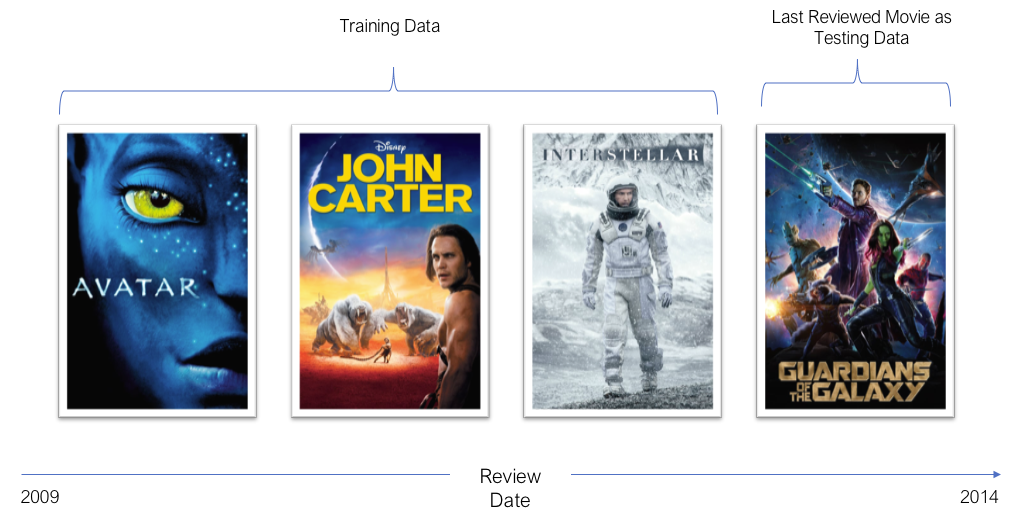

In [ ]:
data['latest_rating'] = data.groupby(['user_id'])['time'].rank(method='first', ascending=False)

train_data = data[data['latest_rating'] != 1] 
test_data = data[data['latest_rating'] == 1]

# use only those columns which would be required
train_data = train_data[['user_id', 'movie_id', 'rating']]
test_data = test_data[['user_id', 'movie_id', 'rating']]

# Converting the dataset into an implicit feedback dataset

While talking about feedback given by user to the item, we categorize these feedbacks into two categories:
1. __Explicit Feedback__: These include _direct_ and _quantitative_ feedback from user. For example, clicking on the like/dislike button on youtube, giving ratings to product on Amazon, writing comment about the product in reviews on Flipkart, etc.

2. __Implicit Feedback__: Feedback collected indirectly from user _interactions_. For example, watching a video on youtube, items that you browse on Amazon, etc.

Now that we know the difference between explicit and implicit feedback, we can see that explicit feedbacks are often very rare. Take our example, whenever we stream a video on youtube we generally don't give any comments or press the like button; our interaction is limited to us watching the video.


However, implicit feedback has its shortcomings as well. Unlike explict feedbacks, every interaction is assumend to be positive and we are unable to capture negative preferences from users. How then do we capture negative feedback? One technique that can be applied is negative sampling, which we will go through in a later section.

In [ ]:
train_data.loc[:, 'rating'] = 1  # Convert all ratings into 1
train_data.sample(5)

Well now we have a problem though. After binarizing our dataset, we see that every instance in the dataset now becomes to the positive class, i.e, 1. However we also require a negative samples to train our model (negative samples indicate that the user has not interacted with the movie). 

So we randomly assume some interactions to be negative; we'll think that user are not interested in them - even though this a sweeping assumption that may not be true.

In [ ]:
# Code to generate ratings in the ratio of negative to positive samples as 4:1

movie_ids = data['movie_id'].unique()  # list of all movies

users, movies, labels = [], [], []

# This is the set of items that each user has interaction with
user_item_set = set(zip(train_data['user_id'], train_data['movie_id']))

# 4:1 ratio of negative to positive samples
num_negatives = 4

for (user, movie) in tqdm(user_item_set):
    users.append(user)
    movies.append(movie)
    labels.append(1)
    for _ in range(num_negatives):
        # randomly select a movie
        negative_movie = np.random.choice(movie_ids)
        # check that the user has not interacted with this item
        while (user, negative_movie) in user_item_set:
            negative_movie = np.random.choice(movie_ids)
        users.append(user)
        movies.append(negative_movie)
        labels.append(0)  # items not interacted are negative

Let's now define a class does which all the work we have so far done:

In [ ]:
class MovielensTrainDataset(Dataset):
    def __init__(self, data, movie_ids):
        self.data = data
        self.movie_ids = movie_ids
        self.users, self.movies, self.labels = self.get_dataset(data, movie_ids)
    
    def __getitem__(self, idx):
        return self.users[idx], self.movies[idx], self.labels[idx]
    
    def __len__(self):
        return len(self.users)
    
    def get_dataset(self, data, movie_ids):
        users, movies, labels = [], [], []

        # This is the set of items that each user has interaction with
        user_item_set = set(zip(train_data['user_id'], train_data['movie_id']))

        # 4:1 ratio of negative to positive samples
        num_negatives = 4

        for (user, movie) in tqdm(user_item_set):
            users.append(user)
            movies.append(movie)
            labels.append(1)
            for _ in range(num_negatives):
                # randomly select a movie
                negative_movie = np.random.choice(movie_ids)
                # check that the user has not interacted with this item
                while (user, negative_movie) in user_item_set:
                    negative_movie = np.random.choice(movie_ids)
                users.append(user)
                movies.append(negative_movie)
                labels.append(0)  # items not interacted are negative
        return torch.tensor(users), torch.tensor(movies), torch.tensor(labels)

# NEURAL COLLABRATIVE FILTERING

As we see in recent years deep learning has come out to be a new giant in the field of Artificial Intelligence. However, the exploration of deep neural networks on recommender systems has received relatively less scrutiny. 

Although some recent work has employed deep learning for recommendation, they primarily used it to model auxiliary information, such as textual descriptions of items and acoustic features of musics. When it comes to model the key factor in collaborative filtering -- the interaction between user and item features, they still resorted to matrix factorization and applied an inner product on the latent features of users and items. 

## Matrix Factorization

The whole algorithm work as:
* Factorise the sparse ratings matrix into a less dimensional latent feature matrix for users and items.
* These latent feature matrix now is dense and thus require less computational power.
* Predict the ratings for a item by the user by doing the inner product of these latent matrix.


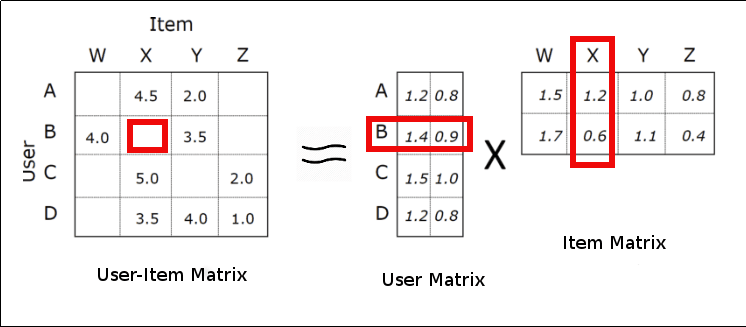

## Limitation of matrix factorization

Though matrix factorization is good but as I mentioned in the last point, it computes the inner product and thus is unable to learn non-linear functions.


Let's see that through an example:
Below is the matrix of ratings for some arbitrary users and items

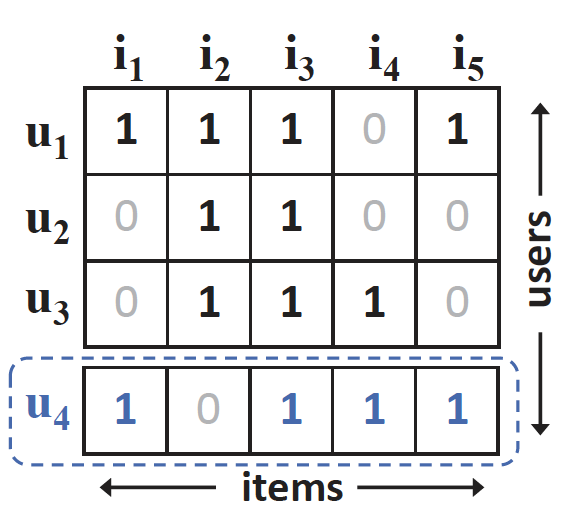

We first focus on the top three top rows of this utility matrix. Let S{x, y} denotes the similarity between user x and user y. By computing the cosine-similarity between users 1, 2, and 3, we know that S{2, 3} > S{1, 2} > S{1, 3}. Without loss of generality, we map the users onto a latent space of two dimensions as the following.

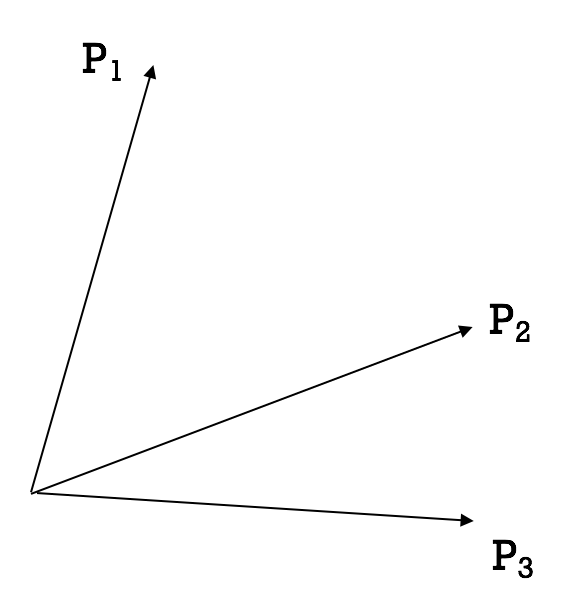

Now, we take into account user 4. Comparing the similarity with the others, we obtain S{1,4} > S{3,4} > S{2,4}. However, no matter we place the latent vector P4 to the right or left of P1, it will inevitably be closer to P2 than P3.


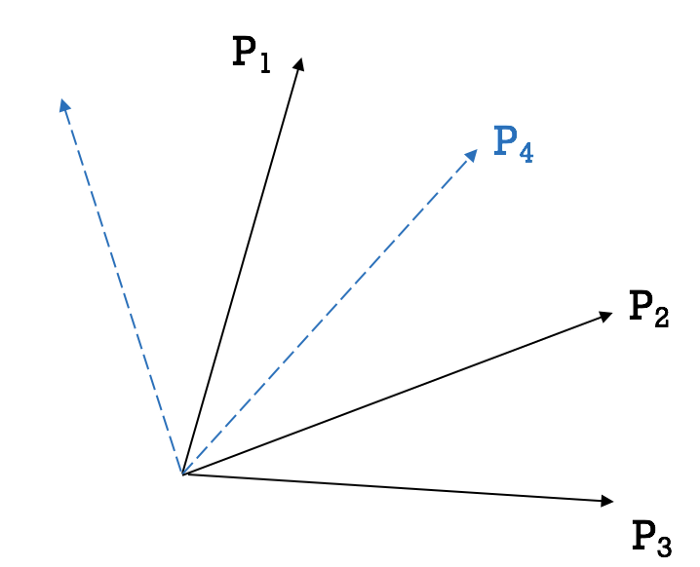

Therefore, this example shows the limitation of inner product to fully model the interactions between user and items in the latent space.


## Neural Collabrative Filtering

The paper argued that we can overcome the model's incapability of learning non-linear functions by employing deep neural networks. 
<br>The paper proposed Neural Collaborative Filtering as shown in the graph below. In the input layer, the user and item are one-hot encoded. Then, they are mapped to the hidden space with embedding layers accordingly. The Neural FC layer can be any kind neuron connections. Multiple layer perceptron, for example, can be placed here. It claims that with the complicated connection and non-linearity in the Neural CF layers, this model is capable of properly estimating the complex interactions between user and item in the latent space.

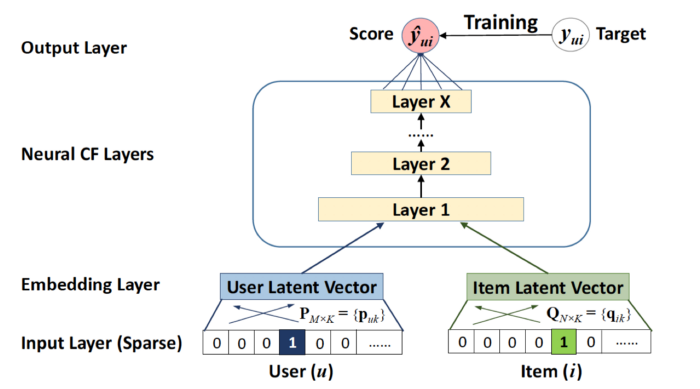

They propose NCF as the generalization of Matrix Factorization. 
<br> We first replace Neural CF layer with a multiplication layer, which performs element-wise multiplication on the two inputs. Then, we set the weight from the multiplication layer to the output layer to be a fixed unit matrix (matrix of all ones ) of dimension K by 1 with linear activation function.

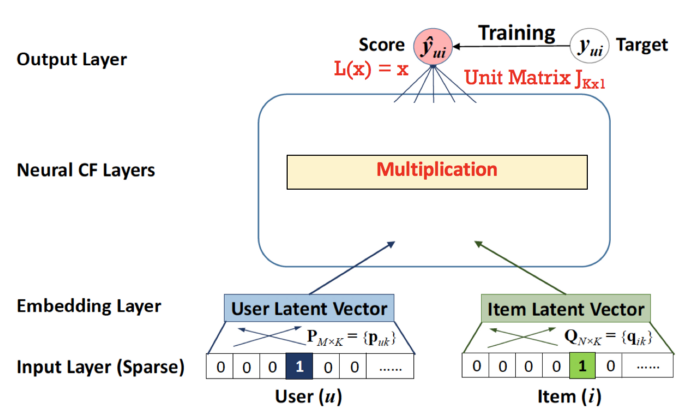

Then, we have the following equations:

Neural Collaborative Filtering (NCF) is a paper published by National University of Singapore, Columbia University, Shandong University, and Texas A&M University in 2017. It utilizes the flexibility, complexity, and non-linearity of Neural Network to build a recommender system. It proves that Matrix Factorization, a traditional recommender system, is a special case of Neural Collaborative Filtering

In [ ]:
class GMF(pl.LightningModule):
    def __init__(self, num_users, num_items, data, movie_ids):
        super().__init__()
        self.num_users = num_users
        self.num_items = num_items
        self.data = data
        self.movie_ids = movie_ids
        
        self.embedding_user = torch.nn.Embedding(num_embeddings=self.num_users, embedding_dim=8, max_norm=True)
        self.embedding_item = torch.nn.Embedding(num_embeddings=self.num_items, embedding_dim=8, max_norm=True)
        self.linear = torch.nn.Linear(in_features=8, out_features=1)
        self.logistic = torch.nn.Sigmoid()
    
    def forward(self, user_indices, item_indices):
        user_embedding = self.embedding_user(user_indices)
        item_embedding = self.embedding_item(item_indices)
        element_wise_product = torch.mul(user_embedding, item_embedding)
        logits = self.linear(element_wise_product)
        rating = self.logistic(logits)
        return rating
    
    def training_step(self, batch, batch_idx):
        user_input, item_input, labels = batch
        predicted_labels = self(user_input, item_input)
        loss = nn.BCELoss()(predicted_labels, labels.view(-1, 1).float())
#         loss = torch.sqrt(nn.MSELoss()(predicted_labels, labels.view(-1, 1).float()))
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), weight_decay=0.01)

    def train_dataloader(self):
        return DataLoader(MovielensTrainDataset(self.data, self.movie_ids),
                          batch_size=512, num_workers=4)

In [ ]:
class NCF(pl.LightningModule):
    """ Neural Collaborative Filtering (NCF)
    
        Args:
            num_users (int): Number of unique users
            num_items (int): Number of unique items
            ratings (pd.DataFrame): Dataframe containing the movie ratings for training
            all_movieIds (list): List containing all movieIds (train + test)
    """
    
    def __init__(self, num_users, num_items, data, movie_ids):
        super().__init__()
        self.user_embedding = nn.Embedding(num_embeddings=num_users, embedding_dim=8)
        self.item_embedding = nn.Embedding(num_embeddings=num_items, embedding_dim=8)
        self.fc1 = nn.Linear(in_features=16, out_features=32)
        self.fc2 = nn.Linear(in_features=32, out_features=16)
        self.output = nn.Linear(in_features=16, out_features=1)
        self.data = data
        self.movie_ids = movie_ids
        
    def forward(self, user_input, item_input):
        
        # Pass through embedding layers
        user_embedded = self.user_embedding(user_input)
        item_embedded = self.item_embedding(item_input)

        # Concat the two embedding layers
        vector = torch.cat([user_embedded, item_embedded], dim=-1)

        # Pass through dense layer
        vector = nn.ReLU()(self.fc1(vector))
        vector = nn.ReLU()(self.fc2(vector))

        # Output layer
        pred = nn.Sigmoid()(self.output(vector))

        return pred
    
    def training_step(self, batch, batch_idx):
        user_input, item_input, labels = batch
        predicted_labels = self(user_input, item_input)
        loss = nn.BCELoss()(predicted_labels, labels.view(-1, 1).float())
#         loss = torch.sqrt(nn.MSELoss()(predicted_labels, labels.view(-1, 1).float()))
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), weight_decay=0.01)

    def train_dataloader(self):
        return DataLoader(MovielensTrainDataset(self.data, self.movie_ids),
                          batch_size=512, num_workers=4)

In [ ]:
class NeuMF(pl.LightningModule):
    def __init__(self, num_users, num_items, latent_dim_mf, latent_dim_mlp, data, movie_ids):
        super().__init__()
        self.num_users = num_users
        self.num_items = num_items
        self.latent_dim_mf = latent_dim_mf
        self.latent_dim_mlp = latent_dim_mlp
        
        # mf part
        self.embedding_user_mf = torch.nn.Embedding(num_embeddings=self.num_users, embedding_dim=self.latent_dim_mf)
        self.embedding_item_mf = torch.nn.Embedding(num_embeddings=self.num_items, embedding_dim=self.latent_dim_mf)
        
        # mlp part
        self.embedding_user_mlp = torch.nn.Embedding(num_embeddings=self.num_users, embedding_dim=self.latent_dim_mlp)
        self.embedding_item_mlp = torch.nn.Embedding(num_embeddings=self.num_items, embedding_dim=self.latent_dim_mlp)
        
        self.fc1 = nn.Linear(in_features=16, out_features=64)
        self.fc2 = nn.Linear(in_features=64, out_features=32)
        self.fc3 = nn.Linear(in_features=32, out_features=8)
#         self.dropout = nn.Dropout(0.5)
        self.logits = nn.Linear(in_features=8+self.latent_dim_mf , out_features=1)
        self.logistic = torch.nn.Sigmoid()
        self.data = data
        self.movie_ids = movie_ids
        
    def forward(self, user_indices, item_indices):
        user_embedding_mf = self.embedding_user_mf(user_indices)
        item_embedding_mf = self.embedding_item_mf(item_indices)
        user_embedding_mlp = self.embedding_user_mlp(user_indices)
        item_embedding_mlp = self.embedding_item_mlp(item_indices)
        
        # mf part
        mf_vector = torch.mul(user_embedding_mf, item_embedding_mf)
        mf_vector = nn.Dropout(p=0.2)(mf_vector)

        # mlp part
        mlp_vector = torch.cat([user_embedding_mlp, item_embedding_mlp], dim=-1)
        m = nn.BatchNorm1d(num_features=16)
        m(mlp_vector)
        mlp_vector = self.fc1(mlp_vector)
        mlp_vector = nn.ReLU()(mlp_vector)
        mlp_vector = nn.Dropout(p=0.2)(mlp_vector)
        
        m = nn.BatchNorm1d(num_features=64)
        m(mlp_vector)
        mlp_vector = self.fc2(mlp_vector)
        mlp_vector = nn.ReLU()(mlp_vector)
        mlp_vector = nn.Dropout(p=0.2)(mlp_vector)
        
        m = nn.BatchNorm1d(num_features=32)
        m(mlp_vector)
        mlp_vector = self.fc3(mlp_vector)
        mlp_vector = nn.ReLU()(mlp_vector)
        mlp_vector = nn.Dropout(p=0.2)(mlp_vector)
        
        
        # concat the mlp and mf part
        vector = torch.cat([mlp_vector, mf_vector], dim=-1)
        logits = self.logits(vector)
        rating = self.logistic(logits)
        return rating
    
    def training_step(self, batch, batch_idx):
        user_indices, item_indices, labels = batch
        predicted_labels = self(user_indices, item_indices)
        loss = nn.BCELoss()(predicted_labels, labels.view(-1, 1).float())
#         loss = torch.sqrt(nn.MSELoss()(predicted_labels, labels.view(-1, 1).float()))
        return loss
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), weight_decay=0.01)
    
    def train_dataloader(self):
        return DataLoader(MovielensTrainDataset(self.data, self.movie_ids),
                         batch_size=512, num_workers=4)

In [ ]:
num_users = data['user_id'].max() + 1
num_items = data['movie_id'].max() + 1

movie_ids = data['movie_id'].unique()

model = NeuMF(num_users, num_items, 8, 8, train_data, movie_ids)
mlp_model = NCF(num_users, num_items, train_data, movie_ids)
gmf_model = GMF(num_users, num_items, train_data, movie_ids)

trainer = pl.Trainer(max_epochs=20, gpus=0, reload_dataloaders_every_epoch=True,
                    progress_bar_refresh_rate=50, logger=False,
                    checkpoint_callback=False)

In [ ]:
%time trainer.fit(gmf_model)

In [ ]:
%time trainer.fit(mlp_model)

In [ ]:
%time trainer.fit(model)

# Evaluating our Recommender System

Unlike conventional machine learning technique where we use Root Mean Square Error (RMSE) and Mean Absolute Error (MAE) metric to evaluate our system, we will use `Hit Ratio @n` to evaluate our model. 


`Hit Ratio @n` is a way of calculating how many _hits_ you have in an n-sized list of ranked items. A _hit_ can be any form interaction that the user have made with the item; like ratings, comment, or even watch. The number n decide whether our predictions should come in top 10 or 1000 (depends on the evaluater).

Here we will use __Hit Ratio @10__. The basic idea is:
* First of all choose 99 random items(movies, in our case) that the user has not interacted with.
* Add to these 99 items with the test items (the actual item that the user interacted with). We now have 100 items.
* Run the model on these 100 items and then select the top 10 items according to their predicted probabilities.
* If our prediction happen to fall within the top 10 items, then we say that this a hit.
* Repeat the process for all users. The Hit Ratio is then the average hits.

In [ ]:
def evaluate(model_name):
    test_user_item_set = set(zip(test_data['user_id'], test_data['movie_id']))

    # Dictionary of all items that each user have interacted
    user_interacted_items = data.groupby('user_id')['movie_id'].apply(list).to_dict()

    hits = []
    for (u, i) in tqdm(test_user_item_set):
        interacted_items = user_interacted_items[u]
        not_interacted_items = set(movie_ids) - set(interacted_items)
        selected_not_interacted = list(np.random.choice(list(not_interacted_items), 99))
        test_items = selected_not_interacted + [i]

        predicted_labels = np.squeeze(model_name(torch.tensor([u]*100), torch.tensor(test_items)).detach().numpy())
        top_10_items = [test_items[i] for i in np.argsort(predicted_labels)[::-1][0:10].tolist()]

        if i in top_10_items: 
            hits.append(1)
        else: 
            hits.append(0)

    print("The Hit Ratio @10 is {:.2f}".format(np.average(hits)))

In [ ]:
evaluate(mlp_model)

In [ ]:
evaluate(model)